In [1]:
# https://github.com/aaaquants/option-volatility-surface/blob/master/VolSurfacePlot.ipynb

import yfinance as yf
from dateutil.parser import parse
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib notebook
#from implied_vol import BlackScholes
from functools import partial
from scipy import optimize
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
import scipy.stats as st


In [2]:
msft = yf.Ticker("MSFT")
msft.options
print("expiries. ", msft.options)
#print(opt.calls['volume']) # calls, count, index, puts
#print(expiry)
lookback_days = 2
history = msft.history(period=str(lookback_days)+'d')['Close'] # make sure we have enough data

expiries.  ('2021-07-16', '2021-07-23', '2021-07-30', '2021-08-06', '2021-08-13', '2021-08-20', '2021-08-27', '2021-09-17', '2021-10-15', '2021-11-19', '2022-01-21', '2022-03-18', '2022-06-17', '2022-09-16', '2023-01-20', '2023-03-17', '2023-06-16')


In [3]:
def CND(X):
 
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / np.sqrt(2*np.pi)*np.exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    
    if X<0:
        w = 1.0-w
 
    return w

def BlackScholes(v,CallPutFlag = 'c',S = 100.,X = 100.,T = 1.,r = 0.01):
 
    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    
    if CallPutFlag=='c':
        return S*CND(d1)-X*np.exp(-r*T)*CND(d2)
 
    else:
        return X*np.exp(-r*T)*CND(-d2)-S*CND(-d1)
    
def calc_impl_vol(price = 5., right = 'c', underlying = 100., strike = 100., time = 1., rf = 0.0, inc = 0.001):
    
    def f(x):
        out = (BlackScholes(x,CallPutFlag=right,S=underlying,X=strike,T=time,r=rf)-price)**2 
        if x < 0.0:
            out += 1000.0 * (x)**2
        return out
  
    return optimize.minimize(f,x0=0.5, tol=1e-8, method='Nelder-Mead')

def plot3D(X,Y,Z,labels=None,title=None):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
 
    ax.plot(X,Y,Z,'o')
      
    if labels is not None:
        if labels[0] is not None:
            ax.set_xlabel(labels[0])
        if labels[1] is not None:
            ax.set_ylabel(labels[1])
        if labels[2] is not None:
            ax.set_zlabel(labels[2])
    if title is not None:
        ax.set_title(title)
    plt.show()
    
def make_surf(X,Y,Z):
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(0.4,1.4,350))
#    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(min(Y),max(Y),350))
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY))
    return XX,YY,ZZ

def mesh_plot2(X,Y,Z,labels=None,title=None):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
    XX,YY,ZZ = make_surf(X,Y,Z)

    ax.plot_surface(XX,YY,ZZ)
    ax.contour(XX,YY,ZZ)
    if labels is not None:
        if 'x' in labels:
            ax.set_xlabel(labels['x'])
        if 'y' in labels:
            ax.set_ylabel(labels['y'])
        if 'z' in labels:
            ax.set_zlabel(labels['z'])
    if title is not None:
        ax.set_title(title)
    plt.show()
    

def ImpliedVolatility(CP,S_0,K,sigma,tau,r,V_market,log=False):
    error    = 1e10; # initial error
    #Handy lambda expressions
    optPrice = lambda sigma: BS_Call_Option_Price(CP,S_0,K,sigma,tau,r)
    vega= lambda sigma: dV_dsigma(S_0,K,sigma,tau,r)
    
    # While the difference between the model and the arket price is large
    # follow the iteration
    n = 1.0 
    while error>10e-10:
        g         = optPrice(sigma) - V_market
        g_prim    = vega(sigma)
        sigma_new = sigma - g / g_prim
    
        #error=abs(sigma_new-sigma)
        error=abs(g)
        sigma=sigma_new;
        if log:
            print('iteration {0} with error = {1}'.format(n,error))
        
        n= n+1
    return sigma

# Vega, dV/dsigma
def dV_dsigma(S_0,K,sigma,tau,r):
    #parameters and value of Vega
    d2   = (np.log(S_0 / float(K)) + (r - 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    value = K * np.exp(-r * tau) * st.norm.pdf(d2) * np.sqrt(tau)
    return value

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    #Black-Scholes Call option price
    d1    = (np.log(S_0 / float(K)) + (r + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

In [4]:
data = []
today = datetime.now()
rf = 0.0
rel_tol = 1e-8
opt_type = 'c'
# T, K/S, price/S
# call
for mat in msft.options:
    opt = msft.option_chain(mat)
    options = opt.calls
    options = options[options['inTheMoney']==False] # only OTM
    options['premium'] = 0.5*(options['bid']+options['ask'])
#    avg_volume = calls['volume'].mean()
    qtile = options['volume'].quantile(0.3)
    for (ind, contract) in options.iterrows():
        if contract['volume'] <= qtile:
            continue
        lastTradeDate = pd.to_datetime(contract['lastTradeDate'].date())
        try:
            underlying = history.loc[lastTradeDate]
        except:
            continue
        strike = contract['strike']
        price = contract['premium']
        tenor = (pd.to_datetime(mat)-today).ceil('D').days
        tenor /= 365.0 # annualization
#         tenor /= 252.0 # annualization
        res = calc_impl_vol(price = price, right = 'c', underlying = underlying, strike = strike, time = tenor, rf = rf)
        ivol = res.x[0]
#         ivol = ImpliedVolatility('C',underlying,strike,sigmaInit,tau,rf,price)
#         if ivol >= 0.6:
#             continue
        price_iv = BlackScholes(ivol,CallPutFlag='c',S=underlying,X=strike,T=tenor,r=rf)
        rel_error = (price - price_iv)/price
        if abs(rel_error) >= rel_tol:
            continue
        else:
            data.append([tenor, opt_type, strike/underlying, price/underlying, ivol, rel_error]) # normalized strike and option price

# put
opt_type = 'p'
for mat in msft.options:
    opt = msft.option_chain(mat)
    options = opt.puts
    options = options[options['inTheMoney']==False] # only OTM
    options['premium'] = 0.5*(options['bid']+options['ask'])
#    avg_volume = calls['volume'].mean()
    qtile = options['volume'].quantile(0.3)
    for (ind, contract) in options.iterrows():
        if contract['volume'] <= qtile:
            continue
        lastTradeDate = pd.to_datetime(contract['lastTradeDate'].date())
        try:
            underlying = history.loc[lastTradeDate]
        except:
            continue
        strike = contract['strike']
        price = contract['premium']
        tenor = (pd.to_datetime(mat)-today).ceil('D').days
        tenor /= 365.0 # annualization
#         tenor /= 252.0 # annualization
        res = calc_impl_vol(price = price, right = 'p', underlying = underlying, strike = strike, time = tenor, rf = rf)
        ivol = res.x[0]
#         ivol = ImpliedVolatility('C',underlying,strike,sigmaInit,tau,rf,price)
#         if ivol >= 0.6:
#             continue
        price_iv = BlackScholes(ivol,CallPutFlag='p',S=underlying,X=strike,T=tenor,r=rf)
        rel_error = (price - price_iv)/price
        if abs(rel_error) >= rel_tol:
            continue
        else:
            data.append([tenor, opt_type, strike/underlying, price/underlying, ivol, rel_error]) # normalized strike and option price

            
            
df = pd.DataFrame(data,columns=['tenor','type','k','price','ivol','rel_error'])
df = df.sort_values(by=['tenor','k']).reset_index(drop=True)
df.dropna(inplace=True)
df.to_csv('ivol_surface.csv',index=False)
tenors = df['tenor'].unique()

C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

<IPython.core.display.Javascript object>


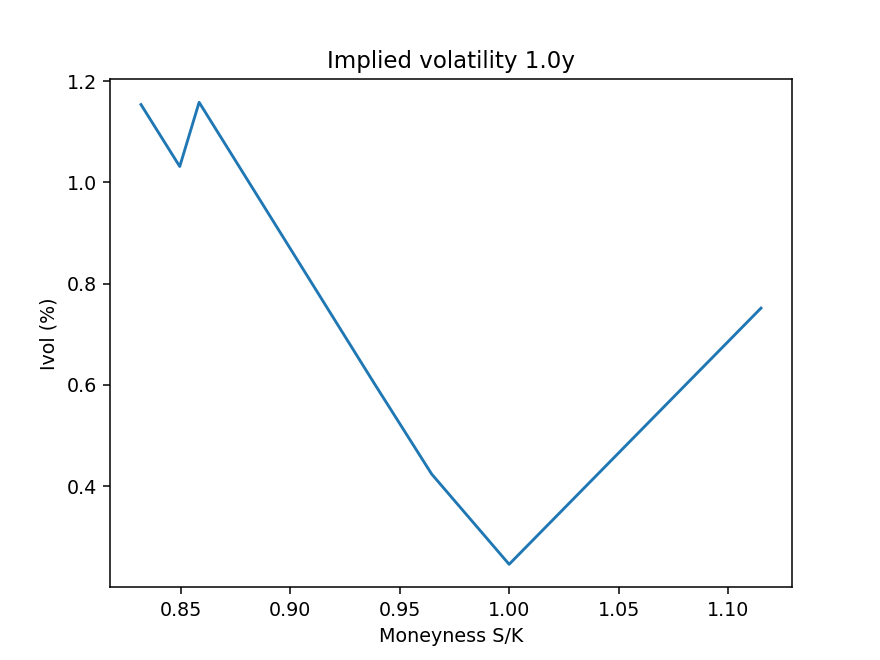

Text(0, 0.5, 'Ivol (%)')

In [5]:
tenor = tenors[0]
x = df[df['tenor']==tenor]['k']
y = df[df['tenor']==tenor]['ivol']
plt.plot(x.values,y.values)
plt.title('Implied volatility '+str(tenor*365)+'y')
plt.xlabel('Moneyness S/K')
plt.ylabel('Ivol (%)')